In [320]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

# model building
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Masking
from tensorflow.keras.metrics import RootMeanSquaredError
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Flatten
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dropout
from keras import layers
from tensorflow.keras import callbacks
from sklearn.preprocessing import MinMaxScaler

# URL Download
import csv
import io
import urllib.request
import requests

# Read in data

In [2]:
!pwd

/home/jakob/code/hmichinaka/berlin-bike-theft-forecasting/notebooks


In [3]:
df_feat = pd.read_csv("../raw_data/daily_features_theft.csv")

In [4]:
df_feat.columns

Index(['Unnamed: 0', 'date', 'min_temp', 'max_temp', 'the_temp',
       'weather_state_name', 'weather_state_abbr', 'wind_speed',
       'wind_direction', 'air_pressure', 'humidity', 'visibility',
       'daylight_hours', 'isholidays', 'weekday', 'weeknum'],
      dtype='object')

In [5]:
df_feat.drop(columns = 'Unnamed: 0', inplace=True )

In [6]:
df_feat.head()

,date,min_temp,max_temp,the_temp,weather_state_name,weather_state_abbr,wind_speed,wind_direction,air_pressure,humidity,visibility,daylight_hours,isholidays,weekday,weeknum
0,2021-01-01,0.005,2.395,2.070,Sleet,sl,3.020726,227.616640,1007.0,93,6.031650,07:50:24,1,4,53
1,2021-01-02,-1.135,3.045,2.465,Heavy Cloud,hc,2.666541,193.699868,1015.0,89,12.863316,07:51:41,0,5,53
2,2021-01-03,-1.315,1.955,0.985,Snow,sn,9.161659,55.677273,1015.0,96,2.144352,07:53:05,0,6,53
3,2021-01-04,0.030,1.780,1.355,Sleet,sl,6.271227,54.331796,1017.0,96,2.927901,07:54:33,0,0,1
4,2021-01-05,-0.030,2.730,1.270,Light Rain,lr,6.009528,26.500356,1017.0,94,7.021805,07:56:08,0,1,1


In [7]:
df_theft = pd.read_csv("../raw_data/bike_theft_cleaned.csv")

In [8]:
df_theft.head()

,Unnamed: 0,date_reported,date_theft_start,hour_theft_start,date_theft_end,hour_theft_end,LOR,estimated_value,attempt,type_bike,theft_type,theft_type_detail,datetime_theft_start,datetime_theft_end,Timedelta_theft_end_start,datetime_theft_mean,BZR,PGR,Bezirk
0,0,2022-02-28,2022-02-26,14:00:00,2022-02-26,14:00:00,7100103,580.0,No,bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2022-02-26 14:00:00,2022-02-26 14:00:00,0.0,2022-02-26 14:00:00,71001,710,7
1,1,2022-02-28,2022-02-28,16:00:00,2022-02-28,16:00:00,2100106,0.0,No,man's bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2022-02-28 16:00:00,2022-02-28 16:00:00,0.0,2022-02-28 16:00:00,21001,210,2
2,2,2022-02-28,2022-02-28,20:00:00,2022-02-28,20:00:00,8300935,0.0,No,other bike,Fahrraddiebstahl,Einfacher Diebstahl von Fahrrädern,2022-02-28 20:00:00,2022-02-28 20:00:00,0.0,2022-02-28 20:00:00,83009,830,8
3,3,2022-02-28,2022-02-28,8:00:00,2022-02-28,8:00:00,4400727,1000.0,No,other bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2022-02-28 08:00:00,2022-02-28 08:00:00,0.0,2022-02-28 08:00:00,44007,440,4
4,4,2022-02-28,2022-02-25,5:00:00,2022-02-25,17:00:00,9100305,499.0,No,man's bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2022-02-25 05:00:00,2022-02-25 17:00:00,12.0,2022-02-25 11:00:00,91003,910,9


# Combine datasets

## Group theft data by Bezirk and date

In [9]:
# Group dataframe by date and LOR
df_theft = df_theft.pivot_table(index = "date_theft_start", columns = "Bezirk", values = "type_bike", aggfunc= "count")

df_theft.fillna(value = 0, inplace=True)

In [10]:
# create "total" column which sums up data for each day
df_theft["total"] = df_theft.sum(axis=1)


df_theft.shape

(424, 13)

In [11]:
df_feat.columns

Index(['date', 'min_temp', 'max_temp', 'the_temp', 'weather_state_name',
       'weather_state_abbr', 'wind_speed', 'wind_direction', 'air_pressure',
       'humidity', 'visibility', 'daylight_hours', 'isholidays', 'weekday',
       'weeknum'],
      dtype='object')

In [12]:
df_theft.columns

Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 'total'], dtype='object', name='Bezirk')

## Merge datasets

We merge the "total" column from the theft dataset with the features from the features dataset

In [13]:
# First we have to reset the index in the df_theft to create a column to merge on 

df_theft.reset_index( inplace=True)

In [14]:
# as the last step we rename the date column to match the name in df_feat
df_theft = df_theft.rename(columns={"date_theft_start": "date"})

In [15]:
df_feat.columns

Index(['date', 'min_temp', 'max_temp', 'the_temp', 'weather_state_name',
       'weather_state_abbr', 'wind_speed', 'wind_direction', 'air_pressure',
       'humidity', 'visibility', 'daylight_hours', 'isholidays', 'weekday',
       'weeknum'],
      dtype='object')

In [16]:
df_theft.columns

Index(['date', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 'total'], dtype='object', name='Bezirk')

berlin-bike-theft-forecasting  MANIFEST.in  README.md	      setup.py
bike_theft_total_daily.csv     notebooks    requirements.txt  tests
Makefile		       raw_data     scripts


In [392]:
!pwd

/home/jakob/code/hmichinaka/berlin-bike-theft-forecasting/notebooks


In [393]:
df_theft[["date", "total"]].to_csv("../bike_theft_total_daily.csv")

In [17]:
# combine the datasets
df_combined = pd.merge(df_feat, df_theft, on = "date")

In [18]:
df_combined.head()

,date,min_temp,max_temp,the_temp,weather_state_name,weather_state_abbr,wind_speed,wind_direction,air_pressure,humidity,...,4,5,6,7,8,9,10,11,12,total
0,2021-01-01,0.005,2.395,2.070,Sleet,sl,3.020726,227.616640,1007.0,93,...,4.0,1.0,0.0,0.0,1.0,1.0,2.0,1.0,0.0,16.0
1,2021-01-02,-1.135,3.045,2.465,Heavy Cloud,hc,2.666541,193.699868,1015.0,89,...,3.0,0.0,1.0,1.0,2.0,2.0,0.0,1.0,1.0,16.0
2,2021-01-03,-1.315,1.955,0.985,Snow,sn,9.161659,55.677273,1015.0,96,...,2.0,0.0,2.0,3.0,0.0,2.0,3.0,0.0,0.0,17.0
3,2021-01-04,0.030,1.780,1.355,Sleet,sl,6.271227,54.331796,1017.0,96,...,4.0,0.0,2.0,4.0,3.0,1.0,0.0,1.0,2.0,33.0
4,2021-01-05,-0.030,2.730,1.270,Light Rain,lr,6.009528,26.500356,1017.0,94,...,5.0,2.0,1.0,5.0,0.0,4.0,0.0,0.0,1.0,29.0


## Select relevant features

In [19]:
df_combined.columns

Index([              'date',           'min_temp',           'max_temp',
                 'the_temp', 'weather_state_name', 'weather_state_abbr',
               'wind_speed',     'wind_direction',       'air_pressure',
                 'humidity',         'visibility',     'daylight_hours',
               'isholidays',            'weekday',            'weeknum',
                          1,                    2,                    3,
                          4,                    5,                    6,
                          7,                    8,                    9,
                         10,                   11,                   12,
                    'total'],
      dtype='object')

- For now we will drop the Bezirke columns, and the weather_state_name as well as weather_state_abbr
- We will also drop min_temp and max_temp and just keep the_temp 
- We will further drop wind_direction

In [20]:
cols_select = ["date", "the_temp", "wind_speed", "air_pressure", "humidity", "visibility", 
              "daylight_hours", "isholidays", "weekday", "weeknum", 
              "total"]

In [21]:
df_combined = df_combined[cols_select]

In [22]:
df_combined.head()

,date,the_temp,wind_speed,air_pressure,humidity,visibility,daylight_hours,isholidays,weekday,weeknum,total
0,2021-01-01,2.070,3.020726,1007.0,93,6.031650,07:50:24,1,4,53,16.0
1,2021-01-02,2.465,2.666541,1015.0,89,12.863316,07:51:41,0,5,53,16.0
2,2021-01-03,0.985,9.161659,1015.0,96,2.144352,07:53:05,0,6,53,17.0
3,2021-01-04,1.355,6.271227,1017.0,96,2.927901,07:54:33,0,0,1,33.0
4,2021-01-05,1.270,6.009528,1017.0,94,7.021805,07:56:08,0,1,1,29.0


In [23]:
df_combined = df_combined.set_index("date")

In [105]:
# Change dtype of daylight_hours from object to float
# first calculate seconds
df_combined["daylight_hours"] = df_combined["daylight_hours"].apply(lambda x: sum(int(x) * 60 ** i for i, x in enumerate(reversed(x.split(':')))))

In [109]:
# then calculate hours as float from the seconds
df_combined["daylight_hours"] = df_combined["daylight_hours"]/3600

In [110]:
df_combined.dtypes

the_temp          float64
wind_speed        float64
air_pressure      float64
humidity            int64
visibility        float64
daylight_hours    float64
isholidays          int64
weekday             int64
weeknum             int64
total             float64
dtype: object

# Train-test-split

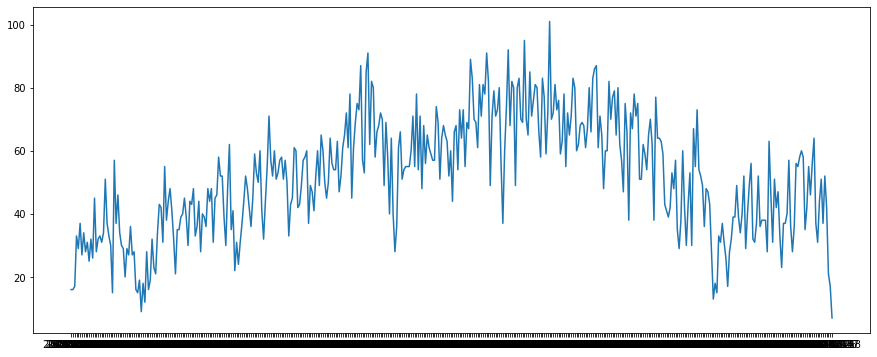

In [411]:
plt.figure(figsize = (15, 6))
plt.plot(df_combined["total"]);

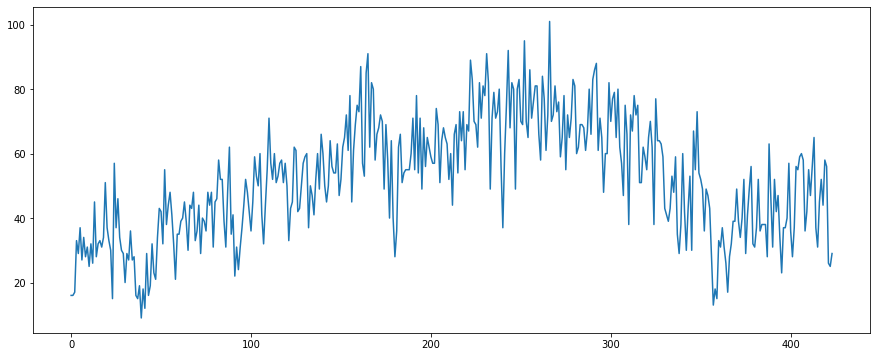

In [451]:
plt.figure(figsize = (15, 6))
plt.plot(df_new["total"][:-3]);

In [112]:
df_combined["total"].mean()

51.62971698113208

In [113]:
df_combined["total"].std()

18.194955888318802

In [114]:
int(len(df_combined) * 0.8)

339

In [115]:
def get_X_y(window_size, future_horizon, dataset):

  X = []
  y = []

  for i in range(0, dataset.shape[0] - window_size - future_horizon):
    X.append(dataset[i: i + window_size])
    y.append(dataset["total"][i + window_size : i + window_size  + future_horizon, ])

  return np.array(X), np.array(y)

In [403]:
window_size = 31
future_horizon = 1

X_train, y_train = get_X_y(window_size,future_horizon, df_combined.iloc[:339, :])
X_test, y_test = get_X_y(window_size, future_horizon, df_combined.iloc[339:, :])

In [404]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((307, 31, 11), (307, 1), (53, 31, 11), (53, 1))

# KFold Cross validation

In [120]:
def model_cross_validation(model):
    model.compile(loss = "mse",
                 optimizer = "adam",
                 metrics = "mean_absolute_percentage_error")
    
    es = callbacks.EarlyStopping(patience = 5, restore_best_weights=True)
    results = []
    kf = KFold(n_splits = 5)
    kf.get_n_splits(X_train)

    for train_index, test_index in kf.split(X_train):

        # split the data into train and test set
        X_train_cv = X_train[train_index]
        X_test_cv = X_train[test_index]
        y_train_cv = y_train[train_index]
        y_test_cv = y_train[test_index]

        model = model 
        
        # Fit the model
        model.fit(X_train_cv, 
                  y_train_cv, 
                  batch_size = 16, 
                  epochs = 300, 
                  verbose = 0, 
                  callbacks = [es], 
                  validation_split = 0.2)
        
        # Evaluate the model on the test data
        results.append(model.evaluate(X_test_cv, y_test_cv))
        
    return results

In [137]:
    kf = KFold(n_splits = 5)
    kf.get_n_splits(X_train)

    for train_index, test_index in kf.split(X_train):
        print(train_index)
        print(test_index)

[ 62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79
  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97
  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115
 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133
 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151
 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169
 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187
 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205
 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223
 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241
 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259
 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277
 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295
 296 297 298 299 300 301 302 303 304 305 306]
[ 0  

# Modelling

## One-dense-layer model

In [121]:
base_model = Sequential([
    Flatten(input_shape=X_train.shape[1:]),
    Dense(1)
])
base_model_cv_results = model_cross_validation(base_model)

2/2 [==============================] - 0s 3ms/step - loss: 549.9778 - mean_absolute_percentage_error: 36.6763


In [128]:
np.mean(base_model_cv_results, axis = 0)

array([402.2815918 ,  32.27479858])

In [123]:
base_model = Sequential([
    Flatten(input_shape=X_train.shape[1:]),
    Dense(1)
])

base_model.compile(loss = "mse",
                 optimizer = "adam",
                 metrics = "mean_absolute_percentage_error")


base_model.fit(X_train, 
                  y_train, 
                  batch_size = 16, 
                  epochs = 300, 
                  verbose = 1, 
                  callbacks = [es], 
                  validation_split = 0.2)

Epoch 1/300
16/16 [==============================] - 0s 7ms/step - loss: 17694.8848 - mean_absolute_percentage_error: 237.1806 - val_loss: 12991.4131 - val_mean_absolute_percentage_error: 181.8492
Epoch 2/300
16/16 [==============================] - 0s 3ms/step - loss: 2632.5046 - mean_absolute_percentage_error: 86.0132 - val_loss: 510.7687 - val_mean_absolute_percentage_error: 34.4657
Epoch 3/300
16/16 [==============================] - 0s 3ms/step - loss: 836.1059 - mean_absolute_percentage_error: 55.5280 - val_loss: 1577.8795 - val_mean_absolute_percentage_error: 56.7494
Epoch 4/300
16/16 [==============================] - 0s 3ms/step - loss: 481.2575 - mean_absolute_percentage_error: 42.1006 - val_loss: 430.5345 - val_mean_absolute_percentage_error: 25.0543
Epoch 5/300
16/16 [==============================] - 0s 3ms/step - loss: 372.7883 - mean_absolute_percentage_error: 36.8090 - val_loss: 655.8307 - val_mean_absolute_percentage_error: 31.9724
Epoch 6/300
16/16 [==================

In [141]:
base_model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 2ms/step - loss: 218.0842 - mean_absolute_percentage_error: 30.7187


[218.08419799804688, 30.718679428100586]

## Finetuned model

In [138]:
opt_model = Sequential()
# first LSTM layer
opt_model.add(LSTM(units = 70, activation = "tanh", return_sequences = True))
opt_model.add(Dropout(0.2))
# second LSTM layer
opt_model.add(LSTM(units= 30, activation= "tanh", return_sequences= False))
opt_model.add(Dropout(0.2))

# output layer to predict one value
opt_model.add(Dense(1, activation= "linear"))


In [133]:
opt_model_cv_results = model_cross_validation(opt_model)

2/2 [==============================] - 0s 9ms/step - loss: 175.1973 - mean_absolute_percentage_error: 17.9930


In [134]:
np.mean(opt_model_cv_results, axis = 0)

array([320.28873901,  36.5918354 ])

In [139]:
opt_model.compile(optimizer= "adam", loss= "mse", metrics = "mean_absolute_percentage_error")
opt_model.fit(X_train, 
                  y_train, 
                  batch_size = 8, 
                  epochs = 300, 
                  verbose = 1, 
                  callbacks = [es], 
                  validation_split = 0.2)

Epoch 1/300
31/31 [==============================] - 4s 40ms/step - loss: 3065.7107 - mean_absolute_percentage_error: 94.6154 - val_loss: 3640.8950 - val_mean_absolute_percentage_error: 92.1738
Epoch 2/300
31/31 [==============================] - 1s 23ms/step - loss: 2701.2507 - mean_absolute_percentage_error: 86.9787 - val_loss: 3314.6418 - val_mean_absolute_percentage_error: 87.5099
Epoch 3/300
31/31 [==============================] - 1s 22ms/step - loss: 2465.7129 - mean_absolute_percentage_error: 81.5947 - val_loss: 3081.4788 - val_mean_absolute_percentage_error: 84.0261
Epoch 4/300
31/31 [==============================] - 1s 22ms/step - loss: 2310.3787 - mean_absolute_percentage_error: 78.1028 - val_loss: 2938.0081 - val_mean_absolute_percentage_error: 81.8128
Epoch 5/300
31/31 [==============================] - 1s 25ms/step - loss: 2192.5305 - mean_absolute_percentage_error: 75.2558 - val_loss: 2821.8494 - val_mean_absolute_percentage_error: 79.9786
Epoch 6/300
31/31 [===========

31/31 [==============================] - 1s 23ms/step - loss: 557.8990 - mean_absolute_percentage_error: 36.7739 - val_loss: 726.7139 - val_mean_absolute_percentage_error: 35.0606
Epoch 44/300
31/31 [==============================] - 1s 23ms/step - loss: 544.5682 - mean_absolute_percentage_error: 35.9751 - val_loss: 702.9022 - val_mean_absolute_percentage_error: 34.4009
Epoch 45/300
31/31 [==============================] - 1s 24ms/step - loss: 524.4957 - mean_absolute_percentage_error: 35.0499 - val_loss: 680.3679 - val_mean_absolute_percentage_error: 33.7631
Epoch 46/300
31/31 [==============================] - 1s 22ms/step - loss: 534.4619 - mean_absolute_percentage_error: 36.0498 - val_loss: 658.4539 - val_mean_absolute_percentage_error: 33.1664
Epoch 47/300
31/31 [==============================] - 1s 25ms/step - loss: 511.7388 - mean_absolute_percentage_error: 35.8525 - val_loss: 638.0563 - val_mean_absolute_percentage_error: 32.6002
Epoch 48/300
31/31 [============================

31/31 [==============================] - 1s 21ms/step - loss: 369.0239 - mean_absolute_percentage_error: 36.6694 - val_loss: 287.8649 - val_mean_absolute_percentage_error: 22.3291
Epoch 86/300
31/31 [==============================] - 1s 20ms/step - loss: 348.3009 - mean_absolute_percentage_error: 36.2017 - val_loss: 284.8858 - val_mean_absolute_percentage_error: 22.2296
Epoch 87/300
31/31 [==============================] - 1s 20ms/step - loss: 335.5416 - mean_absolute_percentage_error: 35.4489 - val_loss: 280.7621 - val_mean_absolute_percentage_error: 22.0898
Epoch 88/300
31/31 [==============================] - 1s 20ms/step - loss: 337.6131 - mean_absolute_percentage_error: 36.2291 - val_loss: 279.8931 - val_mean_absolute_percentage_error: 22.0600
Epoch 89/300
31/31 [==============================] - 1s 20ms/step - loss: 339.0126 - mean_absolute_percentage_error: 35.5871 - val_loss: 276.8725 - val_mean_absolute_percentage_error: 21.9597
Epoch 90/300
31/31 [============================

31/31 [==============================] - 1s 25ms/step - loss: 336.4341 - mean_absolute_percentage_error: 36.8806 - val_loss: 247.1028 - val_mean_absolute_percentage_error: 20.9716
Epoch 128/300
31/31 [==============================] - 1s 24ms/step - loss: 369.8593 - mean_absolute_percentage_error: 38.4581 - val_loss: 247.8633 - val_mean_absolute_percentage_error: 20.9973
Epoch 129/300
31/31 [==============================] - 1s 23ms/step - loss: 353.1997 - mean_absolute_percentage_error: 37.2214 - val_loss: 247.8466 - val_mean_absolute_percentage_error: 20.9967
Epoch 130/300
31/31 [==============================] - 1s 24ms/step - loss: 324.9397 - mean_absolute_percentage_error: 36.4681 - val_loss: 248.2017 - val_mean_absolute_percentage_error: 21.0087
Epoch 131/300
31/31 [==============================] - 1s 23ms/step - loss: 338.7750 - mean_absolute_percentage_error: 36.7851 - val_loss: 248.1608 - val_mean_absolute_percentage_error: 21.0073
Epoch 132/300
31/31 [=======================

In [140]:
opt_model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 11ms/step - loss: 272.6223 - mean_absolute_percentage_error: 42.0692


[272.6222839355469, 42.06920623779297]

# Rolling average

## Calculate rolling average

In [279]:
window_size = 3
# Moving average without center option: 
    #calculate fill value for the beginning of the time series
    #fill_value = df_combined["total"][window_size:window_size*2].mean()
# moving average with center option: 
# calculate fill value: mean of the last seven observations: 
fill_value = df_combined["total"][-window_size].mean()
fill_value

21.0

In [280]:
df_combined["total_moving_average"] = df_combined["total"].rolling(window=window_size, center = True).mean().fillna(fill_value)

In [281]:
df_combined.head(10)

,the_temp,wind_speed,air_pressure,humidity,visibility,daylight_hours,isholidays,weekday,weeknum,total,total_moving_average
date,,,,,,,,,,,
2021-01-01,2.070,3.020726,1007.0,93,6.031650,7.840000,1,4,53,16.0,21.000000
2021-01-02,2.465,2.666541,1015.0,89,12.863316,7.861389,0,5,53,16.0,16.333333
2021-01-03,0.985,9.161659,1015.0,96,2.144352,7.884722,0,6,53,17.0,22.000000
2021-01-04,1.355,6.271227,1017.0,96,2.927901,7.909167,0,0,1,33.0,26.333333
2021-01-05,1.270,6.009528,1017.0,94,7.021805,7.935556,0,1,1,29.0,33.000000
2021-01-06,1.875,3.757435,1010.5,96,6.549874,7.963611,1,2,1,37.0,31.000000
2021-01-07,1.110,6.503004,1009.5,93,4.482572,7.993333,0,3,1,27.0,32.666667
2021-01-08,1.150,3.506091,1012.0,93,4.352084,8.024444,0,4,1,34.0,29.666667
2021-01-09,1.630,3.135630,1020.0,96,5.672498,8.057222,0,5,1,28.0,31.000000


## Feed into model

In [282]:
# For now we only take the total and total_moving_average into account
df_ma = df_combined[["total", "total_moving_average"]]

In [283]:
df_ma.dtypes

total                   float64
total_moving_average    float64
dtype: object

In [284]:
# Train-test-split
int(len(df_ma)* 0.8)

339

In [285]:
window_size = 31
future_horizon = 1

X_train, y_train = get_X_y(window_size,future_horizon, df_ma.iloc[:339, :])
X_test, y_test = get_X_y(window_size, future_horizon, df_ma.iloc[339:, :])

In [286]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((307, 31, 2), (307, 1), (53, 31, 2), (53, 1))

In [287]:
opt_model = Sequential()
# first LSTM layer
opt_model.add(LSTM(units = 70, activation = "tanh", return_sequences = True))
opt_model.add(Dropout(0.2))
# second LSTM layer
opt_model.add(LSTM(units= 30, activation= "tanh", return_sequences= False))
opt_model.add(Dropout(0.2))

# output layer to predict one value
opt_model.add(Dense(1, activation= "linear"))

In [288]:
opt_model_cv_results = model_cross_validation(opt_model)

2/2 [==============================] - 0s 8ms/step - loss: 28.8265 - mean_absolute_percentage_error: 5.1244


In [289]:
np.mean(opt_model_cv_results, axis = 0)[1]

12.918809032440185

In [295]:
X_train.shape

(307, 31, 2)

In [290]:
opt_model = Sequential()
# first LSTM layer
opt_model.add(LSTM(units = 70, activation = "tanh", return_sequences = True))
opt_model.add(Dropout(0.2))
# second LSTM layer
opt_model.add(LSTM(units= 30, activation= "tanh", return_sequences= False))
opt_model.add(Dropout(0.2))

# output layer to predict one value
opt_model.add(Dense(1, activation= "linear"))

In [291]:
opt_model.compile(optimizer= "adam", loss= "mse", metrics = "mean_absolute_percentage_error")
opt_model.fit(X_train, 
                  y_train, 
                  batch_size = 8, 
                  epochs = 300, 
                  verbose = 1, 
                  callbacks = [es], 
                  validation_split = 0.2)

Epoch 1/300
31/31 [==============================] - 4s 47ms/step - loss: 3097.0156 - mean_absolute_percentage_error: 95.2734 - val_loss: 3701.9829 - val_mean_absolute_percentage_error: 93.0206
Epoch 2/300
31/31 [==============================] - 1s 25ms/step - loss: 2740.8184 - mean_absolute_percentage_error: 87.5547 - val_loss: 3344.0103 - val_mean_absolute_percentage_error: 87.9367
Epoch 3/300
31/31 [==============================] - 1s 23ms/step - loss: 2503.8357 - mean_absolute_percentage_error: 82.6000 - val_loss: 3148.4622 - val_mean_absolute_percentage_error: 85.0406
Epoch 4/300
31/31 [==============================] - 1s 22ms/step - loss: 2388.0579 - mean_absolute_percentage_error: 79.8307 - val_loss: 3022.1685 - val_mean_absolute_percentage_error: 83.1177
Epoch 5/300
31/31 [==============================] - 1s 23ms/step - loss: 2289.2441 - mean_absolute_percentage_error: 77.6246 - val_loss: 2911.6206 - val_mean_absolute_percentage_error: 81.3996
Epoch 6/300
31/31 [===========

31/31 [==============================] - 1s 22ms/step - loss: 572.4432 - mean_absolute_percentage_error: 36.3111 - val_loss: 766.0738 - val_mean_absolute_percentage_error: 36.1213
Epoch 44/300
31/31 [==============================] - 1s 22ms/step - loss: 585.4072 - mean_absolute_percentage_error: 36.9778 - val_loss: 740.9496 - val_mean_absolute_percentage_error: 35.4484
Epoch 45/300
31/31 [==============================] - 1s 22ms/step - loss: 560.1224 - mean_absolute_percentage_error: 36.8804 - val_loss: 716.3233 - val_mean_absolute_percentage_error: 34.7745
Epoch 46/300
31/31 [==============================] - 1s 22ms/step - loss: 533.5952 - mean_absolute_percentage_error: 36.2224 - val_loss: 692.7908 - val_mean_absolute_percentage_error: 34.1164
Epoch 47/300
31/31 [==============================] - 1s 22ms/step - loss: 549.1896 - mean_absolute_percentage_error: 36.8775 - val_loss: 671.7682 - val_mean_absolute_percentage_error: 33.5298
Epoch 48/300
31/31 [============================

31/31 [==============================] - 1s 22ms/step - loss: 226.8230 - mean_absolute_percentage_error: 22.1093 - val_loss: 233.1892 - val_mean_absolute_percentage_error: 20.4786
Epoch 86/300
31/31 [==============================] - 1s 22ms/step - loss: 190.5007 - mean_absolute_percentage_error: 21.4556 - val_loss: 228.3828 - val_mean_absolute_percentage_error: 20.2956
Epoch 87/300
31/31 [==============================] - 1s 22ms/step - loss: 199.1673 - mean_absolute_percentage_error: 20.6510 - val_loss: 223.0696 - val_mean_absolute_percentage_error: 20.0868
Epoch 88/300
31/31 [==============================] - 1s 22ms/step - loss: 210.5127 - mean_absolute_percentage_error: 21.6086 - val_loss: 217.9015 - val_mean_absolute_percentage_error: 19.8750
Epoch 89/300
31/31 [==============================] - 1s 21ms/step - loss: 207.8508 - mean_absolute_percentage_error: 21.0230 - val_loss: 213.0337 - val_mean_absolute_percentage_error: 19.6671
Epoch 90/300
31/31 [============================

31/31 [==============================] - 1s 21ms/step - loss: 85.4276 - mean_absolute_percentage_error: 13.5367 - val_loss: 75.1758 - val_mean_absolute_percentage_error: 10.0698
Epoch 128/300
31/31 [==============================] - 1s 22ms/step - loss: 95.3152 - mean_absolute_percentage_error: 13.6250 - val_loss: 75.4897 - val_mean_absolute_percentage_error: 10.8543
Epoch 129/300
31/31 [==============================] - 1s 22ms/step - loss: 91.6424 - mean_absolute_percentage_error: 13.2645 - val_loss: 84.0587 - val_mean_absolute_percentage_error: 12.2144
Epoch 130/300
31/31 [==============================] - 1s 21ms/step - loss: 96.5618 - mean_absolute_percentage_error: 13.5495 - val_loss: 82.2424 - val_mean_absolute_percentage_error: 10.0948
Epoch 131/300
31/31 [==============================] - 1s 22ms/step - loss: 88.7745 - mean_absolute_percentage_error: 13.0571 - val_loss: 65.0032 - val_mean_absolute_percentage_error: 9.1051
Epoch 132/300
31/31 [==============================] - 

Epoch 170/300
31/31 [==============================] - 1s 22ms/step - loss: 59.2240 - mean_absolute_percentage_error: 11.3173 - val_loss: 28.5287 - val_mean_absolute_percentage_error: 7.4628
Epoch 171/300
31/31 [==============================] - 1s 22ms/step - loss: 60.4283 - mean_absolute_percentage_error: 11.2460 - val_loss: 28.0458 - val_mean_absolute_percentage_error: 6.0271
Epoch 172/300
31/31 [==============================] - 1s 21ms/step - loss: 51.2750 - mean_absolute_percentage_error: 10.2535 - val_loss: 24.8255 - val_mean_absolute_percentage_error: 6.4668
Epoch 173/300
31/31 [==============================] - 1s 21ms/step - loss: 47.5146 - mean_absolute_percentage_error: 9.6998 - val_loss: 18.7181 - val_mean_absolute_percentage_error: 4.3631
Epoch 174/300
31/31 [==============================] - 1s 21ms/step - loss: 52.4939 - mean_absolute_percentage_error: 9.8518 - val_loss: 19.3827 - val_mean_absolute_percentage_error: 4.4210
Epoch 175/300
31/31 [==========================

In [292]:
opt_model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 11ms/step - loss: 2.7993 - mean_absolute_percentage_error: 3.5753


[2.7993147373199463, 3.575289487838745]

In [293]:
# Moving average window size = 7
# Result for not-centered moving average: Evaluation on the test set: mean_absolute_percentage_error: 24.9789
#  filled NAs with mean of days 7-14
# Result for centered moving average: Evaluation on the test set: mean_absolute_percentage_error: 17.9939
#  filled NAs with mean of last seven observations of whole dataset

# Moving average window size = 5
# Result for centered moving average: Evaluation on the test set: mean_absolute_percentage_error: 9.5739
# filled NAs with mean of last five observations

# Moving average window size = 3
# Result for centered moving average: Evaluation on the test set: mean_absolute_percentage_error: 4.4171
# filled NAs with mean of last three observations

# Moving average window size = 1
# Result for centered moving average: Evaluation on the test set: mean_absolute_percentage_error: 26.0934
# filled NAs with mean of last observation

In [217]:
df_combined.tail()

,the_temp,wind_speed,air_pressure,humidity,visibility,daylight_hours,isholidays,weekday,weeknum,total,total_moving_average
date,,,,,,,,,,,
2022-02-24,9.210,9.855780,1011.5,67,14.118175,10.592222,0,3,8,52.0,37.714286
2022-02-25,6.305,11.460817,1016.0,64,10.139846,10.659444,0,4,8,42.0,32.428571
2022-02-26,5.950,6.208894,1032.0,77,11.720303,10.726389,0,5,8,21.0,51.000000
2022-02-27,6.175,3.942383,1037.5,72,12.481172,10.793889,0,6,8,17.0,51.000000
2022-02-28,4.985,5.008762,1036.0,57,14.556242,10.861389,0,0,9,7.0,51.000000


In [448]:
df_ma.tail()

,total,total_moving_average
date,,
2022-02-24,52.0,43.666667
2022-02-25,42.0,38.333333
2022-02-26,21.0,26.666667
2022-02-27,17.0,15.000000
2022-02-28,7.0,21.000000


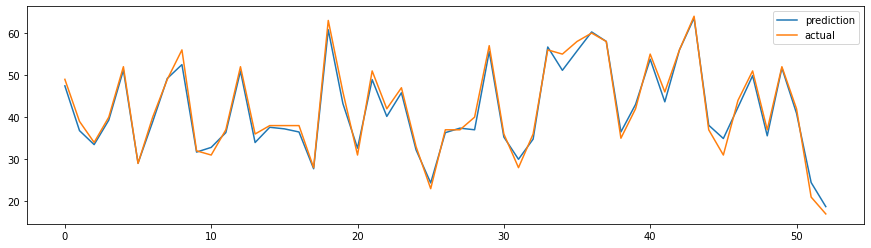

In [399]:
plt.figure(figsize= (15, 4))
plt.plot(opt_model.predict(X_test), label = "prediction")
plt.plot(y_test, label = "actual")
plt.legend();

# Predict on new data

In [311]:
pred_array = np.array(df_combined[[ "total", "total_moving_average"]][-31:])

In [313]:
pred_array.shape

(31, 2)

In [316]:
pred_array = np.expand_dims(pred_array, 0)

In [317]:
pred_array.shape

(1, 31, 2)

In [445]:
opt_model.predict(pred_array)

array([[38.20686]], dtype=float32)

## Read in most recent dataset

In [378]:
url = "https://www.internetwache-polizei-berlin.de/vdb/Fahrraddiebstahl.csv"
download = requests.get(url)
decoded_content = download.content.decode('ISO-8859-1')
file = decoded_content.splitlines()

# cr = csv.reader(file, delimiter=',')
cr = csv.DictReader(file, delimiter=',')
my_list = list(cr)
df_new = pd.DataFrame(my_list)

In [379]:
df_new.head()

,ANGELEGT_AM,TATZEIT_ANFANG_DATUM,TATZEIT_ANFANG_STUNDE,TATZEIT_ENDE_DATUM,TATZEIT_ENDE_STUNDE,LOR,SCHADENSHOEHE,VERSUCH,ART_DES_FAHRRADS,DELIKT,ERFASSUNGSGRUND
0,03.03.2022,02.03.2022,18,02.03.2022,18,04300621,50,Nein,Herrenfahrrad,Keller- und Bodeneinbruch,Sonstiger schwerer Diebstahl in/aus Keller/Bod...
1,03.03.2022,03.03.2022,16,03.03.2022,16,08100314,0,Nein,Mountainbike,Fahrraddiebstahl,Einfacher Diebstahl von Fahrrädern
2,03.03.2022,03.03.2022,02,03.03.2022,02,09200613,0,Nein,Damenfahrrad,Fahrraddiebstahl,Einfacher Diebstahl von Fahrrädern
3,03.03.2022,25.02.2022,08,25.02.2022,17,06300633,950,Nein,Herrenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
4,03.03.2022,01.03.2022,06,03.03.2022,16,08100208,710,Nein,Damenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern


In [380]:
eng_col_names = [
    "date_reported",
    "date_theft_start",
    "hour_theft_start",
    "date_theft_end",
    "hour_theft_end",
    "LOR",
    "estimated_value",
    "attempt",
    "type_bike", 
    "theft_type",
    "theft_type_detail"    
]
df_new.columns = eng_col_names

In [381]:
df_new.dtypes

date_reported        object
date_theft_start     object
hour_theft_start     object
date_theft_end       object
hour_theft_end       object
LOR                  object
estimated_value      object
attempt              object
type_bike            object
theft_type           object
theft_type_detail    object
dtype: object

In [382]:
df_new["date_theft_start"] =  pd.to_datetime(df_new["date_theft_start"], format='%d.%m.%Y')

In [383]:
df_new.dtypes

date_reported                object
date_theft_start     datetime64[ns]
hour_theft_start             object
date_theft_end               object
hour_theft_end               object
LOR                          object
estimated_value              object
attempt                      object
type_bike                    object
theft_type                   object
theft_type_detail            object
dtype: object

In [384]:
# Group dataframe by date and LOR
df_new = df_new.pivot_table(index = "date_theft_start", values = "type_bike", aggfunc= "count")

df_new.fillna(value = 0, inplace=True)

In [385]:
df_new = df_new.rename(columns={"type_bike": "total"})

In [386]:
df_new = df_new.reset_index()

In [387]:
df_new.columns

Index(['date_theft_start', 'total'], dtype='object')

In [447]:
df_new[df_new.date_theft_start == "2022-03-01"]

,date_theft_start,total
424,2022-03-01,35


In [444]:
df_ma["total"].tail(10)

date
2022-02-19    37.0
2022-02-20    31.0
2022-02-21    44.0
2022-02-22    51.0
2022-02-23    37.0
2022-02-24    52.0
2022-02-25    42.0
2022-02-26    21.0
2022-02-27    17.0
2022-02-28     7.0
Name: total, dtype: float64

In [443]:
df_new[:-3].tail(10)

,date_theft_start,total
414,2022-02-19,37
415,2022-02-20,31
416,2022-02-21,45
417,2022-02-22,52
418,2022-02-23,44
419,2022-02-24,58
420,2022-02-25,56
421,2022-02-26,26
422,2022-02-27,25
423,2022-02-28,29


In [360]:
df_combined.shape

(424, 11)

__---------------------------------------------------------------------------------------------------------------------------__

__---------------------------------------------------------------------------------------------------------------------------__


# Cutoff the last 3 days for the prediction

## Create test and train arrays

In [427]:
def get_X_y_cutoff(window_size, future_horizon, n_cutoff, dataset):

  X = []
  y = []

  for i in range(0, dataset.shape[0] - window_size - future_horizon):
    X.append(dataset[i: i + window_size])
    y.append(dataset["total"][i + window_size + n_cutoff : i + window_size + n_cutoff + future_horizon, ])

  return np.array(X), np.array(y)

In [432]:
int((len(df_ma) - 3) * 0.8)

336

In [463]:
df_ma = df_ma.reset_index(drop = True)

In [ ]:
type(df_)

In [464]:
window_size = 31
future_horizon = 1
n_cutoff = 3

X_train_cut, y_train_cut = get_X_y_cutoff(window_size,future_horizon, n_cutoff, df_ma.iloc[:336, :])
X_test_cut, y_test_cut = get_X_y_cutoff(window_size, future_horizon, n_cutoff, df_ma.iloc[336:, :])

/tmp/ipykernel_1374/3114406080.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(X), np.array(y)


In [465]:
X_train_cut.shape, y_train_cut.shape, X_test_cut.shape, y_test_cut.shape

((304, 31, 2), (304,), (56, 31, 2), (56,))

## Re-Run model on cutoff data

In [466]:
opt_model = Sequential()
# first LSTM layer
opt_model.add(LSTM(units = 70, activation = "tanh", return_sequences = True))
opt_model.add(Dropout(0.2))
# second LSTM layer
opt_model.add(LSTM(units= 30, activation= "tanh", return_sequences= False))
opt_model.add(Dropout(0.2))

# output layer to predict one value
opt_model.add(Dense(1, activation= "linear"))

In [467]:
y_train_cut[0]

34    27.0
Name: total, dtype: float64

In [480]:
type(X_train_cut[0][0][0])

numpy.float64

In [475]:
type(X_train_cut[0][0][1])

numpy.float64

In [468]:
opt_model.compile(optimizer= "adam", loss= "mse", metrics = "mean_absolute_percentage_error")
opt_model.fit(X_train_cut, 
                  y_train_cut, 
                  batch_size = 8, 
                  epochs = 300, 
                  verbose = 1, 
                  callbacks = [es], 
                  validation_split = 0.2)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type Series).